# Module 3.1: Construct Dynamic Circuits  

> Task 3.1 from the IBM Qiskit v2.x Study Guide.  
> Sub-topics: `if_test`, `if_else`, `for_loop`, `while_loop`.  

**References**  
- IBM Docs: Classical Feedforward & Control Flow  
  https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow  
- Fake backend choice: `FakeFractionalBackend` supports `if_else` and `while_loop`.

In [1]:
# Metadata: print versions at runtime.
import qiskit, sys
from qiskit_ibm_runtime import __version__ as ibm_runtime_version
from qiskit.visualization import plot_histogram

print("Python :", sys.version.split()[0])
print("Qiskit  :", qiskit.__version__)
print("qiskit-ibm-runtime :", ibm_runtime_version)

# Minimal imports used across this notebook
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, generate_preset_pass_manager
from qiskit_ibm_runtime import SamplerV2, QiskitRuntimeService
import numpy as np
rng = np.random.default_rng(12345)

Python : 3.12.9
Qiskit  : 2.2.1
qiskit-ibm-runtime : 0.41.1


To see which of your backends support dynamic circuits:

In [2]:
service = QiskitRuntimeService()
dc_backends = service.backends(dynamic_circuits=True)
print(dc_backends)

[<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]


## 1) Conceptual Overview  

Dynamic circuits allow real-time classical control within a quantum program.  
They enable mid-circuit measurement and conditional branching.  

**Key ideas**  
- *Classical feedforward:* Measure a qubit and use the result to control later ops.  
- *Control flow:* Use constructs like `if_test`, `if_else`, `for_loop`, and  
  `while_loop` to branch and iterate at runtime.  
- *Execution model:* Qiskit lowers control flow into OpenQASM 3 with classical  
  conditions evaluated on device.

## 2) Hands-on Examples (baseline)  

We use a fake backend that supports dynamic circuits to build and run examples  
via `SamplerV2`. We always transpile with  
`generate_preset_pass_manager(backend=...)` before `run`.

In [3]:
qc0 = QuantumCircuit(1, 1, name="baseline")
qc0.h(0)
qc0.measure(0, 0)
from qiskit_ibm_runtime.fake_provider import FakeFractionalBackend

# Helper for transpiling with preset PM and running safely.
backend = FakeFractionalBackend()

pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
cir_isa = pm.run(qc0)

sampler = SamplerV2(mode=backend)  # v2.x API
job = sampler.run([cir_isa], shots=30)
results = job.result()
results[0].join_data().get_counts()

{'1': 10, '0': 20}

## 3) Focused Exam-style Skills (Task 3.1)  

Each sub-module introduces one control-flow method with:  
- A short explanation and doc links.  
- A minimal executable example.  
- A quick exercise.

### 3.1.0  `if_test` — measured condition controls a block  

**Docs**  
- https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow  

**Idea**  
Measure qubit $q_0$ into classical $c_0$, then if $c_0=1$ apply an $X$ to $q_1$.

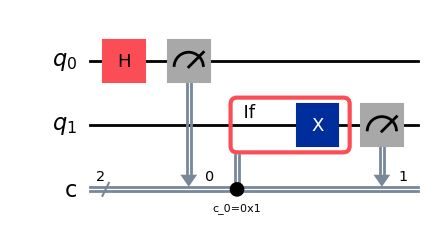

In [4]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

q = QuantumRegister(2, "q")
c = ClassicalRegister(2, "c")
qc_if = QuantumCircuit(q, c, name="if_test_demo")

qc_if.h(q[0])               # Put q0 into superposition
qc_if.measure(q[0], c[0])   # Mid-circuit measurement

with qc_if.if_test((c[0], 1)):
    qc_if.x(q[1])           # Apply X to q1 only if c0 == 1

qc_if.measure(q[1], c[1])

qc_if.draw(output="mpl")

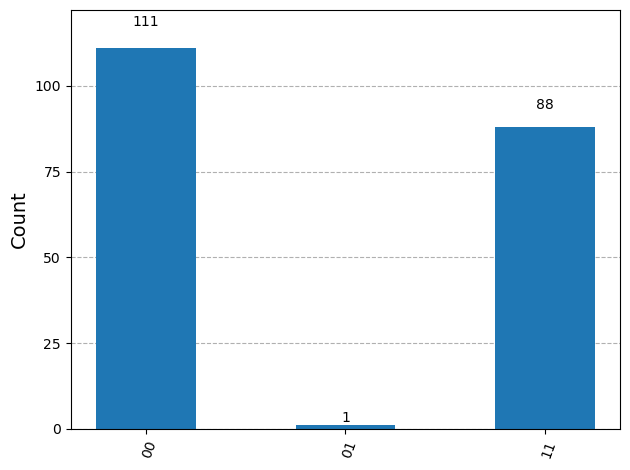

In [5]:
backend = FakeFractionalBackend()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
cir_isa = pm.run(qc_if)

# --- run with SamplerV2 and build counts ---
sampler = SamplerV2(mode=backend)
job = sampler.run([cir_isa], shots=200)
res = job.result()
pub = res[0]  # SamplerPubResult for our single circuit

# Robust way to aggregate per-shot data into counts:
counts = pub.join_data().get_counts()

# --- plot histogram ---
plot_histogram(counts)


**Exercise**  
Change the first gate to `rx(np.pi/3, q[0])` and predict whether the probability  
of measuring `c0=1` increases or decreases compared to `h(q0)`. Then run.

### 3.1.1  `if_else` — two-way branching  

**Docs**  
- https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow  

**Idea**  
Measure $q_0$ into $c_0$. If $c_0=1$ apply $H$ to $q_1$, else apply $X$.

In [6]:
q = QuantumRegister(2, "q")
c = ClassicalRegister(2, "c")
qc_ie = QuantumCircuit(q, c, name="if_else_demo")

qc_ie.h(q[0])
qc_ie.measure(q[0], c[0])

with qc_ie.if_test((c[0], 1)) as else_:
    qc_ie.h(q[1])
with else_:
    qc_ie.x(q[1])

qc_ie.measure(q[1], c[1])


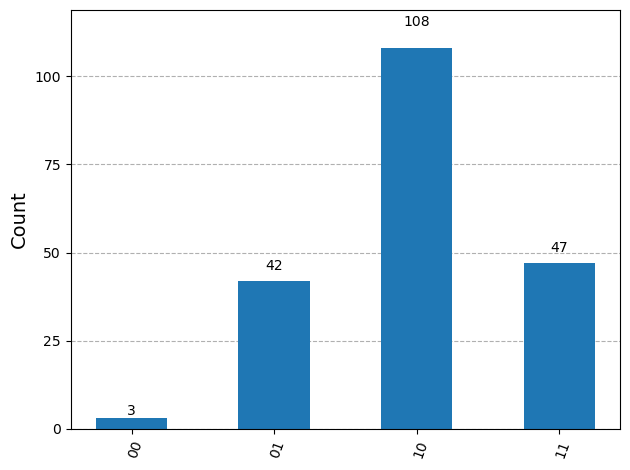

In [7]:
backend = FakeFractionalBackend()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
cir_isa = pm.run(qc_ie)

# --- run with SamplerV2 and build counts ---
sampler = SamplerV2(mode=backend)
job = sampler.run([cir_isa], shots=200)
res = job.result()
pub = res[0]  # SamplerPubResult for our single circuit

# Robust way to aggregate per-shot data into counts:
counts = pub.join_data().get_counts()

# --- plot histogram ---
plot_histogram(counts)


**Exercise**  
Swap the operations in the branches (`H` and `X`). Run again and compare the  
distribution of `c1`.

### 3.1.2  `for_loop` — static repetition with runtime semantics  

**Docs and Notes**  
- https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow
- Note that `for_loop` does not work on all hardware.  In this notebook, we'll use Aer to implement circuits that use the `for_loop` functionality.

**Idea**  
Apply $R_x(\theta)$ three times to $q_0$ using a `for_loop`. For example,  
three applications of $R_x(\pi/4)$ yield a net rotation of $3\pi/4$.

In [8]:
q = QuantumRegister(1, "q")
c = ClassicalRegister(1, "c")
qc_for = QuantumCircuit(q, c, name="for_loop_demo")

theta = np.pi/4
with qc_for.for_loop(range(3)):
    qc_for.rx(theta, q[0])

qc_for.measure(q[0], c[0])


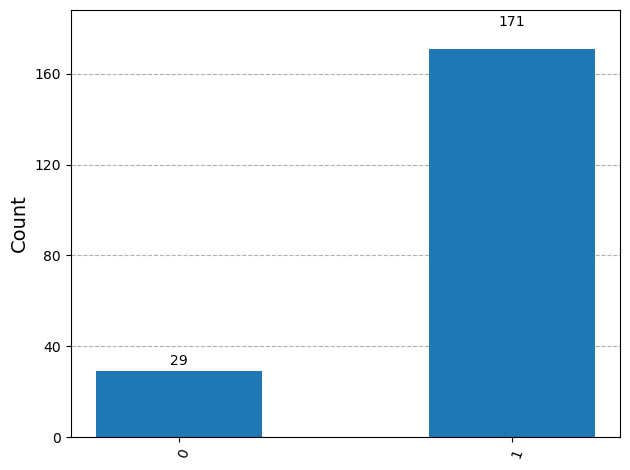

In [9]:
from qiskit_aer.primitives import SamplerV2

sampler = SamplerV2()
cir_isa = qc_for

job = sampler.run([cir_isa], shots=200)
res = job.result()
pub = res[0]  # SamplerPubResult for our single circuit

# Robust way to aggregate per-shot data into counts:
counts = pub.join_data().get_counts()

# --- plot histogram ---
plot_histogram(counts)


**Exercise**  
Change `range(3)` to `range(4)` with the same $\theta=\pi/4$. What outcome do you  
expect for the measurement? Verify.

### 3.1.3  `while_loop` — repeat until classical condition flips  

**Docs**  
- https://quantum.cloud.ibm.com/docs/en/guides/classical-feedforward-and-control-flow  

**Idea**  
Initialize $q_0=\lvert 0\rangle$. While classical bit $c_0=0$, apply $X$ then  
re-measure. This will flip $q_0$ once then exit.

In [10]:
q = QuantumRegister(1, "q")
c = ClassicalRegister(1, "c")
qc_while = QuantumCircuit(q, c, name="while_loop_demo")

qc_while.reset(q[0])
qc_while.measure(q[0], c[0])

with qc_while.while_loop((c[0], 0)):
    qc_while.x(q[0])
    qc_while.measure(q[0], c[0])

print(qc_while.draw(output="text"))

          ┌─┐┌───────── ┌───┐┌─┐ ───────┐ 
  q: ─|0>─┤M├┤ While-0  ┤ X ├┤M├  End-0 ├─
          └╥┘└────╥──── └───┘└╥┘ ───────┘ 
           ║ ┌────╨────┐      ║           
c: 1/══════╩═╡ c_0=0x0 ╞══════╩═══════════
           0 └─────────┘      0           


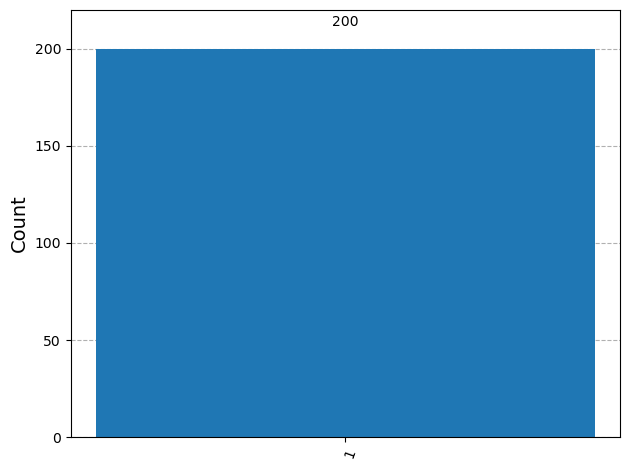

In [11]:
from qiskit_ibm_runtime.fake_provider import FakeFractionalBackend
from qiskit_ibm_runtime import SamplerV2

backend = FakeFractionalBackend()
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
cir_isa = pm.run(qc_while)

# --- run with SamplerV2 and build counts ---
sampler = SamplerV2(mode=backend)
job = sampler.run([cir_isa], shots=200)
res = job.result()
pub = res[0]  # SamplerPubResult for our single circuit

# Robust way to aggregate per-shot data into counts:
counts = pub.join_data().get_counts()

# --- plot histogram ---
plot_histogram(counts)


**Exercise**  
Insert `h(q[0])` before the first measurement and reason about the number of loop  
iterations. Will it always terminate in one pass? Explain after running.

### 3.1.4 Limitations on Dynamic Circuits

Some Terminology:
- "broadcast" : a single transfer of unique classical data.  
- "broadcasted bits": the number of classical bits being transferred

There are limitations on both:
- If you broadcast 60 bits each time, then the job can have approximately **300 broadcasts.**
- If you broadcast one bit each time, however, then the job can have **2400 broadcasts.**

In [12]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
q = QuantumRegister(1); cs = [ClassicalRegister(1) for _ in range(20)]
qc = QuantumCircuit(q, *cs)
for cr in cs:
    qc.measure(q[0], cr[0])
    with qc.if_test((cr[0], 1)): qc.x(q[0])   # ❌ many broadcasts

In [13]:
q = QuantumRegister(1); c = ClassicalRegister(8)
qc = QuantumCircuit(q, c)
qc.measure(q[0], c[0])
with qc.if_test((c[0], 1)): qc.x(q[0])       # ✅ same reg, 1 bit
with qc.if_test((c, 0b00000001)): qc.h(q[0]) # ✅ ≤32-bit compare


#### Operand width too large (>32 bits)

In [14]:
q = QuantumRegister(40); c = ClassicalRegister(40)
qc = QuantumCircuit(q, c); qc.measure(q, c)
with qc.if_test((c, 123456)): qc.x(q[0])     # ❌ >32 bits


In [15]:
with qc.if_test((c[5], 1)): qc.x(q[0])       # ✅ single-bit predicate


In [16]:
# The above circuits won't error unless they are actually submitted to IBM's QPU processors
#  Try running the above circuits on a QPU on your own to see that they result in error.

#### Nested conditions

In [17]:
q = QuantumRegister(2); c = ClassicalRegister(2)
qc = QuantumCircuit(q, c); qc.measure(q, c)
with qc.if_test((c[0], 1)):
    with qc.if_test((c[1], 1)): qc.x(q[0])   # ❌ nested


#### No measure inside condition 

In [18]:
q = QuantumRegister(1); c = ClassicalRegister(1)
qc = QuantumCircuit(q, c); qc.measure(q[0], c[0])
with qc.if_test((c[0], 1)): qc.measure(q[0], c[0])  # ❌ not allowed


#### No arithmetic inside condition

In [19]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
q = QuantumRegister(3); c = ClassicalRegister(3)
qc = QuantumCircuit(q, c); qc.measure(q, c)

### ============= uncomment for error ============= ####
# ❌ INVALID: attempting arithmetic/logic in the condition (parity of c[0], c[1])
# cbits aren’t integers; predicates must be (bit, val) or (register, int<=32 bits)
# with qc.if_test(((c[0], 1) ^ (c[1], 1)) == 1):  # will raise a TypeError at build time
#     qc.x(q[2])


### 3.1.5  Multiple Choice Questions (5 items)  



**Q1.** In `if_test((c0, 1))`, what is checked at runtime?  
A. The quantum state of qubit 0 equals $\lvert 1\rangle$.  
B. The classical bit `c0` stores value 1.  
C. The last operation on qubit 0 was `x`.  
D. The circuit depth exceeds 1.  

**Q2.** Which snippet best implements *two-way* branching based on `c0`?  
A. `with qc.if_test((c0,1)): qc.x(0)`  
B. `with qc.if_test((c0,1)) as else_: qc.x(0); with else_: qc.z(0)`  
C. `with qc.for_loop(range(2)): qc.x(0)`  
D. `with qc.while_loop((c0,1)): qc.x(0)`  

**Q3.** Consider the loop below with $\theta=\pi/6$:  
```python
with qc.for_loop(range(6)):
    qc.rx(theta, 0)
```  
What is the net rotation about $X$ (mod $2\pi$)?  
A. $\pi/6$  
B. $\pi/2$  
C. $\pi$  
D. $2\pi$  

**Q4.** Which statement about `while_loop` is most accurate?  
A. It is unrolled at transpile-time to a fixed number of iterations.  
B. It evaluates a classical condition during execution and may terminate early.  
C. It requires an `if_else` inside to terminate.  
D. It cannot include measurements.  

**Q5.** You must transpile before `run`. Which approach fits the Study Guide  
best for this notebook?  
A. `tqc = transpile(qc, basis_gates=['cx','rz'])`  
B. `pm = generate_preset_pass_manager(backend); tqc = pm.run(qc)`  
C. `tqc = qc` because primitives transpile internally.  
D. No transpilation is needed on fake backends.  

<details>
<summary><b>Answer Key</b></summary>

- Q1: **B**  
- Q2: **B**  
- Q3: **C** (six times $\pi/6$ equals $\pi$)  
- Q4: **B**  
- Q5: **B**  

</details>